<a href="https://colab.research.google.com/github/c-bujari/CAP4630/blob/master/HW_4/HW_4_Problem_3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4 - Problem 3b
###CAP 4630 Artificial Intelligience
####Clyde Bujari

The following code is directly pulled from [the professor's example model](https://colab.research.google.com/drive/1F-RWvoxH8MmT7c1UmNy41iuOp-ejiLoF#scrollTo=Fh6gZSeAjF7c) as we were instructed. The convolutional base model is left the same as in my first notebook for this problem, but the classifier is changed.

## Downloading and Preparing the Data

Download and extract the example data, a zip of 2000 JPG pictures of cats and dogs.

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 14:04:16--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  83.4MB/s    in 0.8s    

2020-04-21 14:04:17 (83.4 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note: Google did not provide a test set in this data set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with pre-trained convolution base and custom densely connected layers
Using: ResNet50v2

For reasoning, see my Problem 3a.


### Load and freeze the convolutional base

In [5]:
from keras.applications import VGG16
from keras.applications import ResNet50V2

conv_base = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))

Using TensorFlow backend.


94674944/94668760 [==============================] - 9s 0us/step


In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In this second notebook, I have added a 128-node fully connected layer after the 256-node one also present in my first notebook. 

I have also added a MaxPooling2D layer after the convolutional base, which should help alleviate any overfitting present even more 

(I am not sure if maxpooling can be considered part of the classifier? [This image from the slides](https://github.com/schneider128k/machine_learning_course/blob/master/slides/images/cnn_architecture.png) shows maxpooling layers as part of the Conv. modules, but in this case it is only being used to augment the data prior to processing the fully connected layers)

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 5, 5, 2048)        23564800  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 25,695,233
Trainable params: 2,130,433
Non-trainable params: 23,564,800
__________________________________

## Train the model end to end with frozen convolutional base

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 28s 280ms/step - loss: 0.6506 - acc: 0.6755 - val_loss: 0.2397 - val_acc: 0.8980
Epoch 2/30
100/100 [==============================] - 18s 176ms/step - loss: 0.4652 - acc: 0.7770 - val_loss: 0.4866 - val_acc: 0.9170
Epoch 3/30
100/100 [==============================] - 18s 177ms/step - loss: 0.4363 - acc: 0.7985 - val_loss: 0.2466 - val_acc: 0.9340
Epoch 4/30
100/100 [==============================] - 17s 174ms/step - loss: 0.3970 - acc: 0.8175 - val_loss: 0.6606 - val_acc: 0.9330
Epoch 5/30
100/100 [==============================] - 17s 175ms/step - loss: 0.3918 - acc: 0.8180 - val_loss: 0.2706 - val_acc: 0.9290
Epoch 6/30
100/100 [==============================] - 17s 174ms/step - loss: 0.3637 - acc: 0.8375 - val_loss: 0.2518 - val_acc: 0.9460
Epoch 7/30
100/100 [==============================] - 18s 176ms/step - loss: 0.3466 - acc: 0.8390 - val_lo

## Display curves of loss and accuracy during training

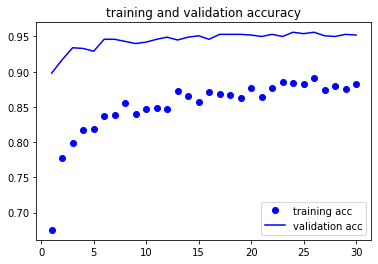

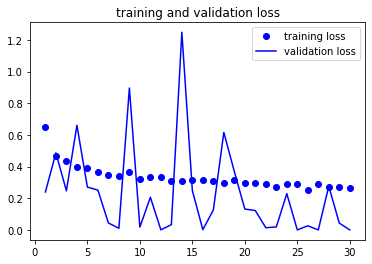

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

Unfreezing the conv base - in my case this process appears to be the same as for VGG16

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [12]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 21s 213ms/step - loss: 0.2711 - acc: 0.8810 - val_loss: 0.2582 - val_acc: 0.9290
Epoch 2/100
100/100 [==============================] - 18s 176ms/step - loss: 0.2489 - acc: 0.8885 - val_loss: 0.1629 - val_acc: 0.9160
Epoch 3/100
100/100 [==============================] - 18s 176ms/step - loss: 0.2506 - acc: 0.8845 - val_loss: 0.0965 - val_acc: 0.9230
Epoch 4/100
100/100 [==============================] - 18s 177ms/step - loss: 0.2398 - acc: 0.8930 - val_loss: 0.4680 - val_acc: 0.9310
Epoch 5/100
100/100 [==============================] - 18s 180ms/step - loss: 0.2428 - acc: 0.8930 - val_loss: 0.0768 - val_acc: 0.9230
Epoch 6/100
100/100 [==============================] - 18s 177ms/step - loss: 0.2439 - acc: 0.8990 - val_loss: 0.0263 - val_acc: 0.9170
Epoch 7/100
100/100 [==============================] - 18s 177ms/step - loss: 0.2381 - acc: 0.8990 - val_loss: 0.2526 - val_acc: 0.9130
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

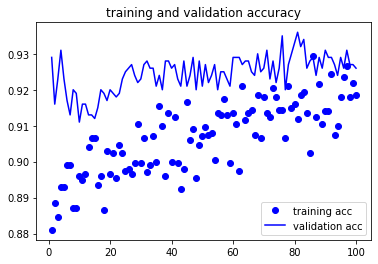

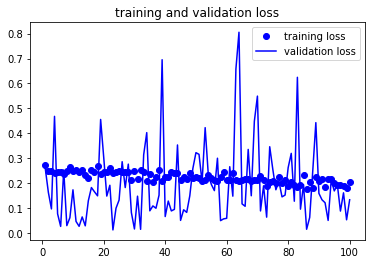

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This classifier's results are very different from the previous 256-node one. 

Adding MaxPool2d before flattening and a 128 node classifier has worsened training accuracy/loss very slightly (at a visual glance, about 0.03 lower accuracy and 0.1 higher loss).

The validation accuracy has also decreased. However, the extremely high variability I saw in the 256-node classifier is much improved (the largest spikes of 1.4 and 1.2 are now down to 0.8 and 0.7, respectively). 

Furthermore, the accuracy graph shows that the model is even freer of overfitting than the 256-node one. The validation accuracy is very similar to the 256-node, and the validation loss has been more than halved. Overall, adding MaxPool2d and an additional 128-node classifier layer appears to be a huge improvement over the 256-node classifier!

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [15]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.08125607669353485
Validation accuracy: 0.9259999990463257


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

The following block of code throws an exception for me despite being exactly copied from the code given to us - I am disregarding this as it does not affect the actual model, and the file can still be manually downloaded through the sidebar at the right.

In [0]:
# from google.colab import files

# with open(model_fname, 'r') as f:
#   files.download(model_fname)

Sources used:


*   https://github.com/schneider128k/machine_learning_course/blob/master/slides/images/cnn_architecture.png
*   https://colab.research.google.com/drive/1F-RWvoxH8MmT7c1UmNy41iuOp-ejiLoF#scrollTo=Fh6gZSeAjF7c
*   https://keras.io/applications/
*   https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

